파일 이름 지정

In [36]:
SAVED_MODEL_FILENAME = "saved_model"
FLOAT_TFL_MODEL_FILENAME = "float_model.tfl"
QUANTIZED_TFL_MODEL_FILENAME = "quantized_model.tfl"
TFL_CC_MODEL_FILENAME = "magic_wand_model_data.cc"

JSON 파일 데이터 받아와서 압축해제


---


> 깃허브 레포 가서 커밋 들어가서 주소창 commit -> archive로 바꾸고 마지막에 .zip



In [37]:
!curl -L https://github.com/Jisu0917/magic_wand_all/archive/5095a5906c29f08442e12118e231eb2ac0a354e3.zip -o magic_wand_data.zip
!unzip magic_wand_data.zip
!rm -rf magic_wand_data
!mv -f magic_wand_all-* magic_wand_data
!rm -rf magic_wand_data.zip
!rm -rf sample_data
!mkdir -p checkpoints

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  304k    0  304k    0     0   559k      0 --:--:-- --:--:-- --:--:--  559k
Archive:  magic_wand_data.zip
5095a5906c29f08442e12118e231eb2ac0a354e3
   creating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/alphabet_a.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/alphabet_b.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/digit_0.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/digit_1.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/digit_2.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/digit_3.json  
  inflating: magic_wand_all-5095a

digit, figure, alphabet 스트로크 데이터 처리

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
import glob
import json

# 데이터셋 경로 설정
digit_files = glob.glob("magic_wand_data/digit_*.json")
figure_files = glob.glob("magic_wand_data/figure_*.json")
alphabet_files = glob.glob("magic_wand_data/alphabet_*.json")

# 데이터셋 생성
digit_dataset = []
figure_dataset = []
alphabet_dataset = []

strokes1 = []
strokes2 = []
strokes3 = []

strokesF1 = []
strokesF2 = []
strokesF3 = []

# digit 데이터 처리
for filename in digit_files:
    with open(filename, "r") as file_digit:
        file_digit_contents = file_digit.read()
        file_digit_data = json.loads(file_digit_contents)
        digit_dataset.append((file_digit_data, 1))  # flag 값 1 추가
        for stroke in file_digit_data["strokes"]:
          stroke["filename"] = filename
          strokes1.append(stroke)
          strokesF1.append((stroke,1))

# figure 데이터 처리
for filename in figure_files:
    with open(filename, "r") as file_figure:
        file_figure_contents = file_figure.read()
        file_figure_data = json.loads(file_figure_contents)
        figure_dataset.append((file_figure_data, 2))  # flag 값 2 추가
        for stroke in file_figure_data["strokes"]:
          stroke["filename"] = filename
          strokes2.append(stroke)
          strokesF2.append((stroke,2))

# alphabet 데이터 처리
for filename in alphabet_files:
    with open(filename, "r") as file_alphabet:
        file_alphabet_contents = file_alphabet.read()
        file_alphabet_data = json.loads(file_alphabet_contents)
        alphabet_dataset.append((file_alphabet_data, 3))  # flag 값 3 추가
        for stroke in file_alphabet_data["strokes"]:
          stroke["filename"] = filename
          strokes3.append(stroke)
          strokesF3.append((stroke,3))


스트로크 그려보기

In [40]:
import matplotlib.pyplot as plt

def plot_stroke(stroke):

  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

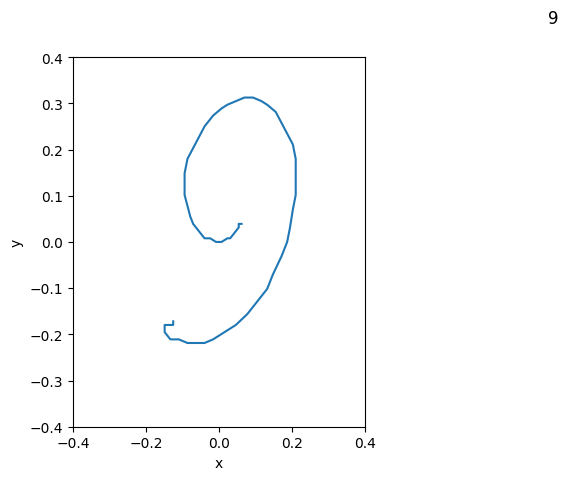

In [41]:
plot_stroke(strokes1[11])

rasterize_stroke : 스트로크를 래스터화 해주는 함수

In [43]:
import math
import numpy as np
import PIL

FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue

  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

숫자 데이터 래스터화 해보기

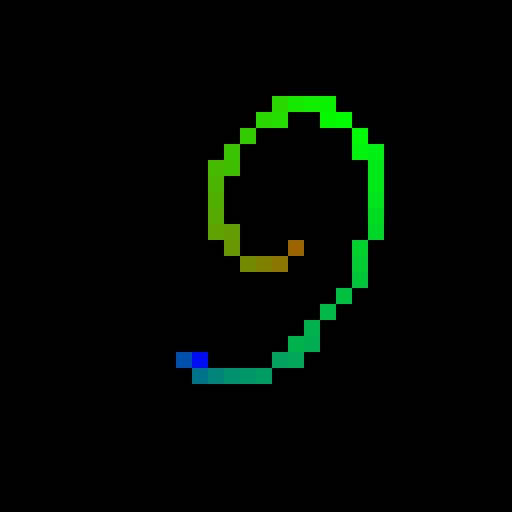

In [44]:
raster1 = rasterize_stroke(strokes1[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster1).resize((512, 512), PIL.Image.NEAREST)

도형 데이터 래스터화 해보기

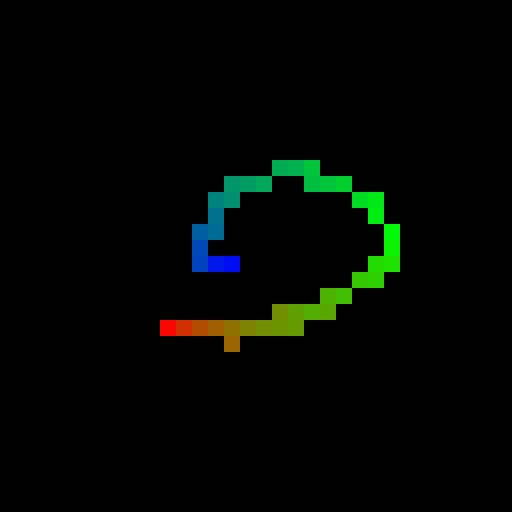

In [45]:
raster2 = rasterize_stroke(strokes2[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster2).resize((512, 512), PIL.Image.NEAREST)

알파벳 데이터 래스터화 해보기

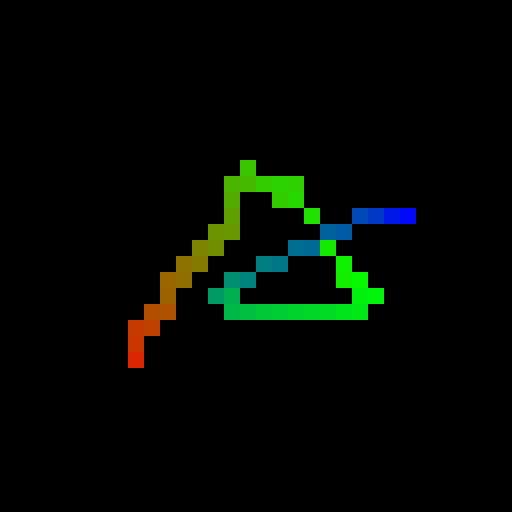

In [46]:
raster3 = rasterize_stroke(strokes3[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster3).resize((512, 512), PIL.Image.NEAREST)

In [47]:
from pathlib import Path
import shutil

X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points


스트로크를 png 이미지로 저장하는 함수

In [48]:
def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
    ensure_empty_dir(root_folder)
    labels = set()
    for stroke in strokes:
        labels.add(stroke[0]["label"].lower())
    for label in labels:
        label_path = Path(root_folder, label)
        ensure_empty_dir(label_path)

    label_counts = {}
    for stroke in strokes:
        points = stroke[0]["strokePoints"]
        label = stroke[0]["label"].lower()
        if label == "":
            raise Exception("Missing label for %s:%d" % (stroke[0]["filename"], stroke[0]["index"]))
        if label not in label_counts:
            label_counts[label] = 0
        label_count = label_counts[label]
        label_counts[label] += 1
        raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
        image = PIL.Image.fromarray(raster)
        image.save(Path(root_folder, label, str(label_count) + ".png"))
        for i in range(augment_count):
            augmented_points = augment_points(points, 0.1, 0.1, 0.3)
            raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
            image = PIL.Image.fromarray(raster)
            image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))


테스트 셋, 검증 셋, 트레이닝 셋 각각에 대해 이미지 생성

In [51]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

# 데이터셋 분할 및 이미지 생성
shuffled_strokesF = strokesF1 + strokesF2 + strokesF3
np.random.shuffle(shuffled_strokesF)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokesF) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokesF) * validation_percentage) / 100)
test_strokes = shuffled_strokesF[0:test_count]
validation_strokes = shuffled_strokesF[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokesF[(test_count + validation_count):]

# 테스트 셋에 대해 이미지 생성
save_strokes_as_images(test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

# 검증 셋에 대해 이미지 생성
save_strokes_as_images(validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, 0)

# 트레이닝 셋에 대해 이미지 생성
save_strokes_as_images(train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

검증 셋과 트레이닝 셋에 대한 데이터셋 정의

In [52]:
validation_ds = image_dataset_from_directory(
    directory='validation',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory='train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

Found 126 files belonging to 15 classes.
Found 11143 files belonging to 15 classes.


트레이닝 데이터셋 첫 번째 셋 그려보기

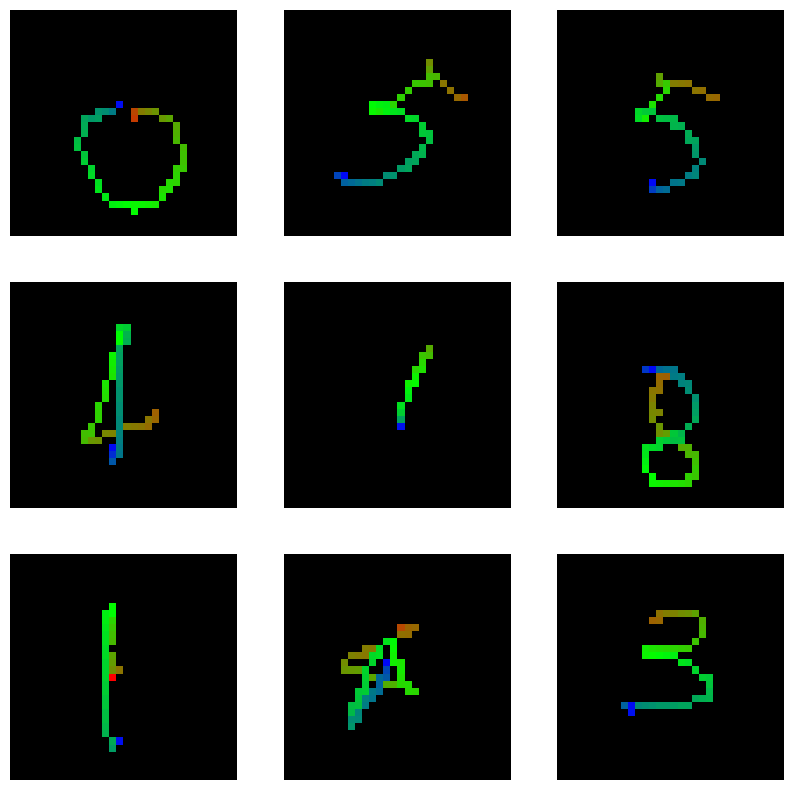

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

모델 생성 함수

In [59]:
from keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

모델을 생성하고 컴파일 및 실행

In [61]:
model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=15)
keras.utils.plot_model(model, show_shapes=True)

epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds,
)

Epoch 1/30
349/349 [==============================] - 10s 22ms/step - loss: 0.2976 - accuracy: 0.1027 - val_loss: 0.2486 - val_accuracy: 0.0794


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
349/349 [==============================] - 7s 21ms/step - loss: 0.2388 - accuracy: 0.1705 - val_loss: 0.2130 - val_accuracy: 0.2540
Epoch 3/30
349/349 [==============================] - 7s 21ms/step - loss: 0.2255 - accuracy: 0.2277 - val_loss: 0.1908 - val_accuracy: 0.5556
Epoch 4/30
349/349 [==============================] - 6s 17ms/step - loss: 0.2135 - accuracy: 0.2811 - val_loss: 0.1742 - val_accuracy: 0.6667
Epoch 5/30
349/349 [==============================] - 7s 20ms/step - loss: 0.2029 - accuracy: 0.3319 - val_loss: 0.1627 - val_accuracy: 0.7540
Epoch 6/30
349/349 [==============================] - 6s 18ms/step - loss: 0.1923 - accuracy: 0.3775 - val_loss: 0.1511 - val_accuracy: 0.6270
Epoch 7/30
349/349 [==============================] - 8s 23ms/step - loss: 0.1840 - accuracy: 0.4162 - val_loss: 0.1594 - val_accuracy: 0.5000
Epoch 8/30
349/349 [==============================] - 7s 21ms/step - loss: 0.1752 - accuracy: 0.4590 - val_loss: 0.1293 - val_accuracy: 0.8175

이미지 예측 함수

In [63]:
import tensorflow as tf
import numpy as np

def predict_image(model, filename):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    return predictions[0]  # 각 클래스에 대한 확률 반환

predictions = predict_image(model, "test/3/1.png")
print(predictions)
predictions = predict_image(model, "test/star/1.png")
print(predictions)
predictions = predict_image(model, "test/a/1.png")
print(predictions)

1/1 [==============================] - 0s 132ms/step
[1.0731629e-04 3.0240328e-06 1.0816599e-01 8.7780672e-01 4.6885565e-05
 1.0033838e-02 1.5158867e-04 7.3130218e-06 2.2791219e-05 2.4909771e-04
 9.2060392e-05 1.2763050e-04 2.3413679e-05 1.0422030e-03 2.1200785e-03]
1/1 [==============================] - 0s 20ms/step
[3.9901240e-03 1.6930706e-08 1.4916024e-02 8.0181053e-03 8.9213978e-03
 8.3504763e-04 4.6010041e-03 2.3741805e-07 4.5838393e-02 5.1676338e-03
 1.4096319e-02 3.2685801e-02 9.5474953e-03 2.2087099e-01 6.3051134e-01]
1/1 [==============================] - 0s 20ms/step
[0.00747318 0.04997648 0.20954095 0.06619744 0.00715306 0.00176858
 0.01623896 0.02650332 0.01152098 0.1565826  0.22637427 0.04119702
 0.12831275 0.03934854 0.01181182]


이미지에 대한 인덱스와 확률 예측 함수

In [64]:
def predict_index(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (predicted_label_index, predicted_score)

index, score = predict_index(model, "test/circle/2_a0.png")

print(index, score)

1/1 [==============================] - 0s 37ms/step
12 0.31390297


라벨에 인덱스를 설정, 이미지에 대한 가장 높은 확률의 인덱스(라벨)를 예측

In [81]:
from IPython.display import Image, display

SCORE_THRESHOLD = 0.75

label_to_index = {"star": 10, "heart": 11, "circle": 12, "a": 13, "b": 14}

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob("test/*"):
    label = label_dir.split("/")[-1]  # 레이블 디렉토리명 가져오기
    print(f'label: {label}')
    for filename in glob.glob(label_dir + "/*.png"):
        # 이미지 로드
        img = tf.keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # 이미지를 배치 차원에 추가

        # 이미지 값을 모델에 전달하여 예측
        predictions = model.predict(img_array)
        print(predictions)

        # softmax 함수를 사용하여 확률로 변환
        probabilities = tf.nn.softmax(predictions)

        # 가장 높은 확률을 가진 클래스의 인덱스
        index = tf.argmax(probabilities, axis=1).numpy()[0]
        score = probabilities[0][index].numpy()  # 해당 클래스의 확률

        if score < SCORE_THRESHOLD:
            discarded_count += 1
            continue

        if index == label_to_index[label]:
            correct_count += 1
        else:
            wrong_count += 1
            print("%s expected, %d found with score %f" % (label, index, score))
            display(Image(filename=filename))

#correct_percentage = (correct_count / (correct_count + wrong_count)) * 100
print("%d correct (wrong %d, %d unknown)" % (correct_count, (wrong_count), discarded_count))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[[4.4564147e-02 2.9644335e-04 3.6273696e-03 6.9137855e-04 5.9341642e-06
  9.7289577e-04 9.4643873e-01 1.2766654e-07 9.0062147e-04 2.8053123e-06
  3.4576606e-05 2.3137517e-03 1.3405623e-05 1.4646262e-06 1.3628780e-04]]
1/1 [==============================] - 0s 21ms/step
[[4.9490789e-03 5.4810989e-05 4.4606216e-03 4.4105208e-04 6.9130128e-06
  4.8971007e-04 9.6336848e-01 1.6369686e-06 4.9836485e-04 7.2700203e-07
  1.2779608e-04 1.6569443e-02 1.2578911e-04 3.4413963e-05 8.8711912e-03]]
1/1 [==============================] - 0s 24ms/step
[[8.9898080e-02 1.3637031e-02 2.6346022e-02 4.4828421e-03 5.5006624e-04
  7.2858809e-03 8.4065485e-01 1.7058809e-06 6.5881889e-03 3.3371366e-04
  7.1854045e-04 8.8119106e-03 2.6185205e-04 2.2406954e-05 4.0692970e-04]]
1/1 [==============================] - 0s 19ms/step
[[1.50862625e-02 1.84079909e-04 1.74145866e-03 4.23439691e-04
  1.67706985e-05 3.69425426e-04 9.75829363e-01 9.12866316e-09
  3.08117853e-03 1.04159744e-0

모델 저장

In [82]:
model.save(SAVED_MODEL_FILENAME)

텐서플로 라이트로 변환

In [83]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob("test/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

31768

In [84]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])

  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)

  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

In [88]:
predict_tflite(model_no_quant_tflite, "test/star/0.png")

(14, 0.9635539)

tflite로 예측해보기

3 expected, 3 found with score 0.820312


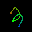

3 expected, 3 found with score 0.875000


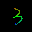

3 expected, 3 found with score 0.902344


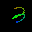

3 expected, 3 found with score 0.773438


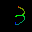

3 expected, 3 found with score 0.875000


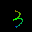

3 expected, 3 found with score 0.917969


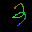

3 expected, 3 found with score 0.910156


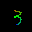

3 expected, 3 found with score 0.941406


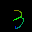

3 expected, 3 found with score 0.894531


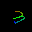

3 expected, 3 found with score 0.804688


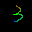

3 expected, 3 found with score 0.859375


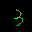

3 expected, 3 found with score 0.855469


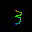

3 expected, 3 found with score 0.835938


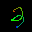

3 expected, 3 found with score 0.765625


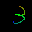

3 expected, 3 found with score 0.824219


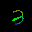

3 expected, 3 found with score 0.808594


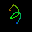

3 expected, 3 found with score 0.781250


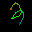

3 expected, 3 found with score 0.902344


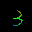

3 expected, 3 found with score 0.878906


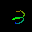

3 expected, 3 found with score 0.785156


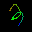

3 expected, 3 found with score 0.882812


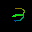

3 expected, 3 found with score 0.847656


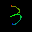

3 expected, 3 found with score 0.789062


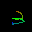

3 expected, 3 found with score 0.921875


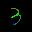

3 expected, 3 found with score 0.960938


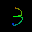

3 expected, 3 found with score 0.785156


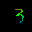

3 expected, 3 found with score 0.949219


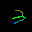

3 expected, 3 found with score 0.824219


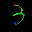

3 expected, 3 found with score 0.847656


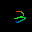

3 expected, 3 found with score 0.816406


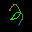

3 expected, 3 found with score 0.812500


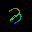

3 expected, 3 found with score 0.808594


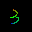

3 expected, 3 found with score 0.941406


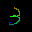

3 expected, 3 found with score 0.898438


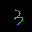

3 expected, 3 found with score 0.878906


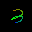

3 expected, 3 found with score 0.832031


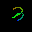

3 expected, 3 found with score 0.910156


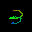

3 expected, 3 found with score 0.921875


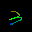

3 expected, 3 found with score 0.863281


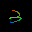

3 expected, 3 found with score 0.851562


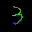

3 expected, 3 found with score 0.875000


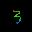

3 expected, 3 found with score 0.882812


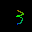

3 expected, 3 found with score 0.910156


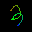

3 expected, 3 found with score 0.851562


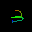

3 expected, 3 found with score 0.820312


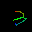

3 expected, 3 found with score 0.910156


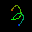

3 expected, 3 found with score 0.875000


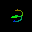

3 expected, 3 found with score 0.984375


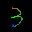

3 expected, 3 found with score 0.917969


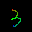

6 expected, 6 found with score 0.921875


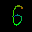

6 expected, 6 found with score 0.972656


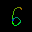

6 expected, 6 found with score 0.972656


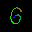

6 expected, 6 found with score 0.917969


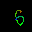

6 expected, 6 found with score 0.976562


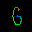

6 expected, 6 found with score 0.949219


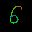

6 expected, 6 found with score 0.980469


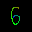

6 expected, 6 found with score 0.921875


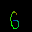

6 expected, 6 found with score 0.921875


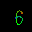

6 expected, 6 found with score 0.976562


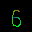

6 expected, 6 found with score 0.812500


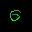

6 expected, 6 found with score 0.929688


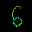

6 expected, 6 found with score 0.972656


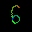

6 expected, 6 found with score 0.921875


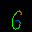

6 expected, 6 found with score 0.945312


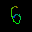

6 expected, 6 found with score 0.906250


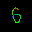

6 expected, 6 found with score 0.945312


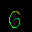

6 expected, 6 found with score 0.964844


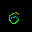

6 expected, 6 found with score 0.839844


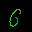

6 expected, 6 found with score 0.976562


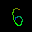

6 expected, 6 found with score 0.988281


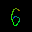

6 expected, 6 found with score 0.980469


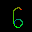

6 expected, 6 found with score 0.964844


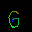

6 expected, 6 found with score 0.894531


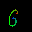

6 expected, 6 found with score 0.812500


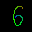

6 expected, 6 found with score 0.906250


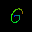

6 expected, 6 found with score 0.972656


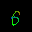

6 expected, 6 found with score 0.867188


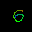

6 expected, 6 found with score 0.988281


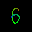

6 expected, 6 found with score 0.976562


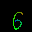

6 expected, 6 found with score 0.863281


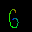

6 expected, 6 found with score 0.855469


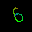

6 expected, 6 found with score 0.949219


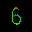

6 expected, 6 found with score 0.949219


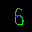

6 expected, 6 found with score 0.902344


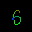

6 expected, 6 found with score 0.910156


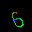

6 expected, 6 found with score 0.894531


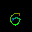

6 expected, 6 found with score 0.894531


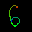

6 expected, 6 found with score 0.882812


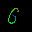

6 expected, 6 found with score 0.968750


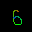

6 expected, 6 found with score 0.957031


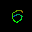

6 expected, 6 found with score 0.835938


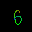

6 expected, 6 found with score 0.972656


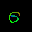

6 expected, 6 found with score 0.953125


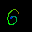

6 expected, 6 found with score 0.968750


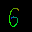

6 expected, 6 found with score 0.976562


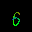

6 expected, 6 found with score 0.921875


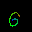

6 expected, 6 found with score 0.960938


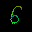

6 expected, 6 found with score 0.898438


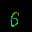

6 expected, 6 found with score 0.980469


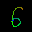

6 expected, 6 found with score 0.960938


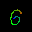

6 expected, 6 found with score 0.964844


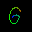

6 expected, 6 found with score 0.976562


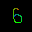

6 expected, 6 found with score 0.832031


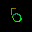

6 expected, 6 found with score 0.984375


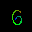

6 expected, 6 found with score 0.835938


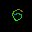

6 expected, 6 found with score 0.976562


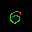

6 expected, 6 found with score 0.949219


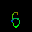

6 expected, 6 found with score 0.976562


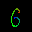

6 expected, 6 found with score 0.906250


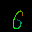

6 expected, 6 found with score 0.933594


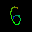

6 expected, 6 found with score 0.992188


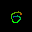

6 expected, 6 found with score 0.886719


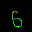

6 expected, 6 found with score 0.886719


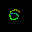

6 expected, 6 found with score 0.988281


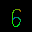

6 expected, 6 found with score 0.953125


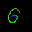

6 expected, 6 found with score 0.921875


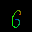

6 expected, 6 found with score 0.929688


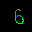

6 expected, 6 found with score 0.933594


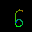

6 expected, 6 found with score 0.957031


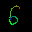

6 expected, 6 found with score 0.929688


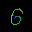

6 expected, 6 found with score 0.980469


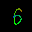

6 expected, 6 found with score 0.980469


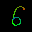

6 expected, 6 found with score 0.984375


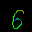

6 expected, 6 found with score 0.910156


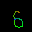

6 expected, 6 found with score 0.980469


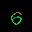

star expected, 14 found with score 0.917969


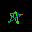

star expected, 14 found with score 0.964844


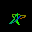

star expected, 14 found with score 0.945312


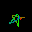

star expected, 14 found with score 0.937500


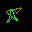

star expected, 14 found with score 0.925781


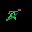

star expected, 14 found with score 0.882812


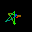

star expected, 14 found with score 0.843750


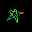

star expected, 14 found with score 0.945312


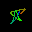

star expected, 14 found with score 0.792969


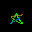

star expected, 14 found with score 0.960938


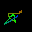

star expected, 14 found with score 0.980469


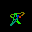

star expected, 14 found with score 0.941406


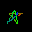

star expected, 14 found with score 0.945312


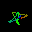

star expected, 14 found with score 0.781250


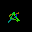

star expected, 14 found with score 0.890625


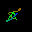

star expected, 14 found with score 0.960938


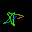

star expected, 14 found with score 0.914062


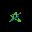

star expected, 14 found with score 0.902344


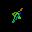

star expected, 14 found with score 0.906250


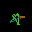

star expected, 14 found with score 0.800781


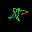

star expected, 14 found with score 0.964844


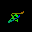

star expected, 14 found with score 0.878906


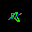

star expected, 14 found with score 0.941406


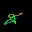

star expected, 14 found with score 0.925781


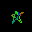

star expected, 14 found with score 0.792969


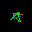

star expected, 14 found with score 0.835938


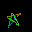

star expected, 14 found with score 0.968750


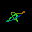

star expected, 14 found with score 0.953125


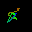

star expected, 14 found with score 0.773438


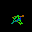

star expected, 14 found with score 0.968750


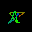

star expected, 14 found with score 0.957031


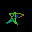

star expected, 14 found with score 0.968750


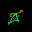

star expected, 14 found with score 0.933594


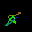

star expected, 14 found with score 0.949219


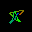

star expected, 14 found with score 0.898438


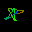

star expected, 14 found with score 0.804688


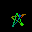

star expected, 14 found with score 0.843750


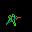

star expected, 14 found with score 0.855469


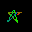

star expected, 14 found with score 0.890625


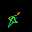

7 expected, 7 found with score 0.988281


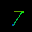

7 expected, 7 found with score 0.957031


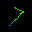

7 expected, 7 found with score 0.863281


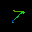

7 expected, 7 found with score 0.964844


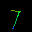

7 expected, 7 found with score 0.988281


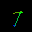

7 expected, 7 found with score 0.867188


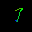

7 expected, 7 found with score 0.949219


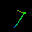

7 expected, 7 found with score 0.890625


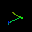

7 expected, 7 found with score 0.921875


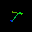

7 expected, 7 found with score 0.980469


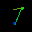

7 expected, 7 found with score 0.921875


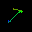

7 expected, 7 found with score 0.949219


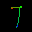

7 expected, 7 found with score 0.941406


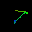

7 expected, 7 found with score 0.949219


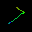

7 expected, 7 found with score 0.812500


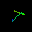

7 expected, 7 found with score 0.949219


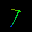

7 expected, 7 found with score 0.765625


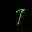

7 expected, 7 found with score 0.808594


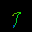

7 expected, 7 found with score 0.972656


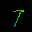

7 expected, 7 found with score 0.980469


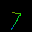

7 expected, 7 found with score 0.968750


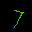

7 expected, 7 found with score 0.847656


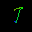

7 expected, 7 found with score 0.972656


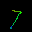

7 expected, 7 found with score 0.855469


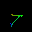

7 expected, 7 found with score 0.980469


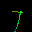

7 expected, 7 found with score 0.964844


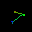

7 expected, 7 found with score 0.933594


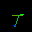

7 expected, 7 found with score 0.984375


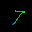

7 expected, 7 found with score 0.972656


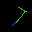

7 expected, 7 found with score 0.968750


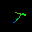

7 expected, 7 found with score 0.984375


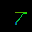

7 expected, 7 found with score 0.988281


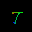

7 expected, 7 found with score 0.984375


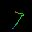

7 expected, 7 found with score 0.777344


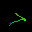

7 expected, 7 found with score 0.941406


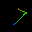

7 expected, 7 found with score 0.945312


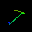

7 expected, 7 found with score 0.953125


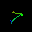

7 expected, 7 found with score 0.871094


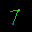

7 expected, 7 found with score 0.957031


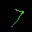

7 expected, 7 found with score 0.984375


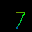

7 expected, 7 found with score 0.941406


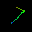

7 expected, 7 found with score 0.925781


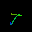

7 expected, 7 found with score 0.898438


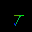

7 expected, 7 found with score 0.976562


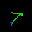

7 expected, 7 found with score 0.972656


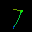

7 expected, 7 found with score 0.968750


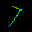

7 expected, 7 found with score 0.980469


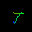

7 expected, 7 found with score 0.894531


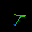

7 expected, 7 found with score 0.878906


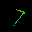

7 expected, 7 found with score 0.957031


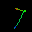

7 expected, 7 found with score 0.960938


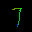

7 expected, 7 found with score 0.953125


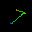

7 expected, 7 found with score 0.984375


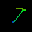

7 expected, 7 found with score 0.937500


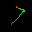

7 expected, 7 found with score 0.835938


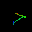

7 expected, 7 found with score 0.925781


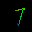

7 expected, 7 found with score 0.789062


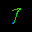

7 expected, 7 found with score 0.945312


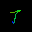

5 expected, 5 found with score 0.945312


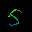

5 expected, 5 found with score 0.988281


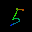

5 expected, 5 found with score 0.886719


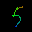

5 expected, 5 found with score 0.972656


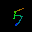

5 expected, 5 found with score 0.984375


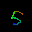

5 expected, 5 found with score 0.960938


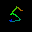

5 expected, 5 found with score 0.949219


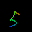

5 expected, 5 found with score 0.953125


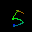

5 expected, 5 found with score 0.945312


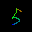

5 expected, 5 found with score 0.855469


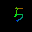

5 expected, 5 found with score 0.988281


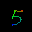

5 expected, 5 found with score 0.945312


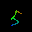

5 expected, 5 found with score 0.886719


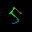

5 expected, 5 found with score 0.972656


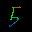

5 expected, 5 found with score 0.792969


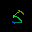

5 expected, 5 found with score 0.886719


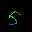

5 expected, 5 found with score 0.976562


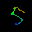

5 expected, 5 found with score 0.824219


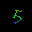

5 expected, 5 found with score 0.937500


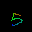

5 expected, 5 found with score 0.984375


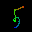

5 expected, 5 found with score 0.972656


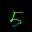

5 expected, 5 found with score 0.953125


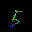

5 expected, 5 found with score 0.984375


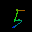

5 expected, 5 found with score 0.929688


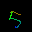

5 expected, 5 found with score 0.808594


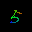

5 expected, 5 found with score 0.832031


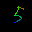

5 expected, 5 found with score 0.945312


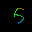

5 expected, 5 found with score 0.972656


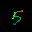

5 expected, 5 found with score 0.894531


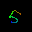

5 expected, 5 found with score 0.937500


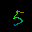

5 expected, 5 found with score 0.976562


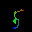

5 expected, 5 found with score 0.910156


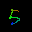

5 expected, 5 found with score 0.945312


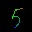

5 expected, 5 found with score 0.761719


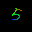

5 expected, 5 found with score 0.957031


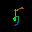

5 expected, 5 found with score 0.890625


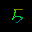

5 expected, 5 found with score 0.972656


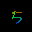

5 expected, 5 found with score 0.960938


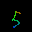

5 expected, 5 found with score 0.988281


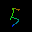

5 expected, 5 found with score 0.957031


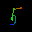

5 expected, 5 found with score 0.976562


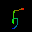

5 expected, 5 found with score 0.976562


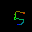

5 expected, 5 found with score 0.960938


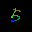

5 expected, 5 found with score 0.984375


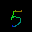

5 expected, 5 found with score 0.941406


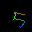

5 expected, 5 found with score 0.773438


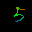

5 expected, 5 found with score 0.800781


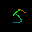

5 expected, 5 found with score 0.914062


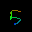

5 expected, 5 found with score 0.949219


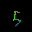

5 expected, 5 found with score 0.964844


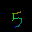

5 expected, 5 found with score 0.890625


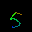

5 expected, 5 found with score 0.949219


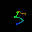

5 expected, 5 found with score 0.945312


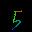

5 expected, 5 found with score 0.921875


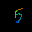

5 expected, 5 found with score 0.957031


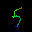

5 expected, 5 found with score 0.964844


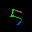

5 expected, 5 found with score 0.878906


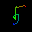

5 expected, 5 found with score 0.906250


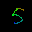

5 expected, 5 found with score 0.976562


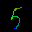

5 expected, 5 found with score 0.906250


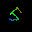

5 expected, 5 found with score 0.953125


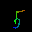

5 expected, 5 found with score 0.949219


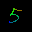

5 expected, 5 found with score 0.750000


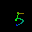

5 expected, 5 found with score 0.960938


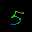

5 expected, 5 found with score 0.925781


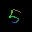

5 expected, 5 found with score 0.921875


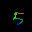

5 expected, 5 found with score 0.871094


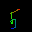

5 expected, 5 found with score 0.851562


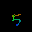

5 expected, 5 found with score 0.953125


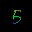

5 expected, 5 found with score 0.925781


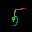

5 expected, 5 found with score 0.917969


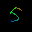

5 expected, 5 found with score 0.968750


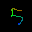

5 expected, 5 found with score 0.921875


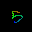

5 expected, 5 found with score 0.976562


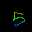

5 expected, 5 found with score 0.953125


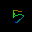

5 expected, 5 found with score 0.945312


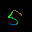

5 expected, 5 found with score 0.906250


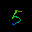

5 expected, 5 found with score 0.968750


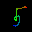

5 expected, 5 found with score 0.816406


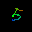

5 expected, 5 found with score 0.894531


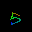

5 expected, 5 found with score 0.835938


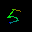

5 expected, 5 found with score 0.937500


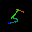

5 expected, 5 found with score 0.945312


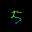

5 expected, 5 found with score 0.796875


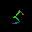

5 expected, 5 found with score 0.984375


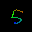

5 expected, 5 found with score 0.953125


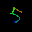

5 expected, 5 found with score 0.953125


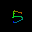

5 expected, 5 found with score 0.914062


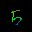

5 expected, 5 found with score 0.984375


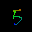

5 expected, 5 found with score 0.894531


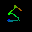

5 expected, 5 found with score 0.816406


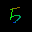

5 expected, 5 found with score 0.953125


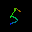

5 expected, 5 found with score 0.964844


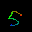

5 expected, 5 found with score 0.953125


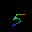

5 expected, 5 found with score 0.796875


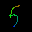

5 expected, 5 found with score 0.968750


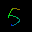

5 expected, 5 found with score 0.890625


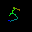

5 expected, 5 found with score 0.957031


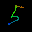

5 expected, 5 found with score 0.750000


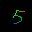

5 expected, 5 found with score 0.859375


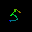

5 expected, 5 found with score 0.953125


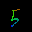

5 expected, 5 found with score 0.785156


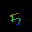

5 expected, 5 found with score 0.957031


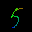

5 expected, 5 found with score 0.890625


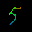

5 expected, 5 found with score 0.949219


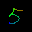

5 expected, 5 found with score 0.980469


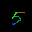

5 expected, 5 found with score 0.964844


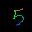

5 expected, 5 found with score 0.957031


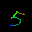

5 expected, 5 found with score 0.968750


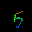

5 expected, 5 found with score 0.949219


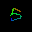

5 expected, 5 found with score 0.972656


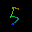

5 expected, 5 found with score 0.957031


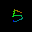

5 expected, 5 found with score 0.964844


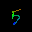

5 expected, 5 found with score 0.968750


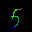

5 expected, 5 found with score 0.941406


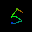

5 expected, 5 found with score 0.890625


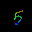

5 expected, 5 found with score 0.917969


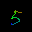

5 expected, 5 found with score 0.976562


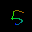

5 expected, 5 found with score 0.890625


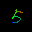

5 expected, 5 found with score 0.972656


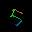

5 expected, 5 found with score 0.949219


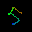

5 expected, 5 found with score 0.792969


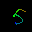

5 expected, 5 found with score 0.984375


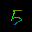

5 expected, 5 found with score 0.953125


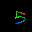

5 expected, 5 found with score 0.882812


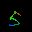

5 expected, 5 found with score 0.941406


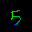

5 expected, 5 found with score 0.910156


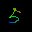

5 expected, 5 found with score 0.855469


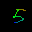

5 expected, 5 found with score 0.976562


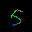

5 expected, 5 found with score 0.980469


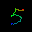

5 expected, 5 found with score 0.988281


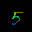

5 expected, 5 found with score 0.929688


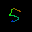

5 expected, 5 found with score 0.960938


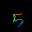

5 expected, 5 found with score 0.972656


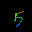

5 expected, 5 found with score 0.945312


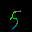

5 expected, 5 found with score 0.937500


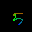

5 expected, 5 found with score 0.882812


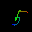

5 expected, 5 found with score 0.925781


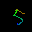

5 expected, 5 found with score 0.855469


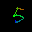

5 expected, 5 found with score 0.933594


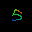

5 expected, 5 found with score 0.964844


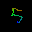

5 expected, 5 found with score 0.921875


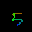

5 expected, 5 found with score 0.960938


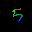

5 expected, 5 found with score 0.894531


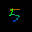

5 expected, 5 found with score 0.941406


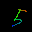

5 expected, 5 found with score 0.937500


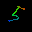

5 expected, 5 found with score 0.925781


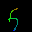

5 expected, 5 found with score 0.976562


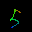

5 expected, 5 found with score 0.898438


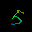

5 expected, 5 found with score 0.980469


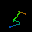

5 expected, 5 found with score 0.808594


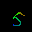

5 expected, 5 found with score 0.964844


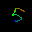

5 expected, 5 found with score 0.960938


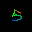

5 expected, 5 found with score 0.988281


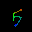

5 expected, 5 found with score 0.800781


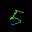

1 expected, 1 found with score 0.964844


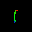

1 expected, 1 found with score 0.996094


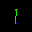

1 expected, 1 found with score 0.812500


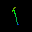

1 expected, 1 found with score 0.992188


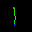

1 expected, 1 found with score 0.972656


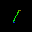

1 expected, 1 found with score 0.996094


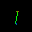

1 expected, 1 found with score 0.996094


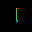

1 expected, 1 found with score 0.906250


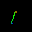

1 expected, 1 found with score 0.835938


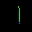

1 expected, 1 found with score 0.992188


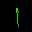

1 expected, 1 found with score 0.996094


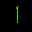

1 expected, 1 found with score 0.992188


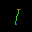

1 expected, 1 found with score 0.992188


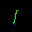

1 expected, 1 found with score 0.972656


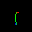

1 expected, 1 found with score 0.988281


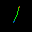

1 expected, 1 found with score 0.875000


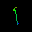

1 expected, 1 found with score 0.773438


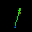

1 expected, 1 found with score 0.949219


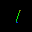

1 expected, 1 found with score 0.996094


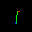

1 expected, 1 found with score 0.988281


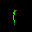

1 expected, 1 found with score 0.976562


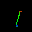

1 expected, 1 found with score 0.988281


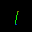

1 expected, 1 found with score 0.980469


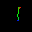

1 expected, 1 found with score 0.890625


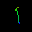

1 expected, 1 found with score 0.996094


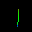

1 expected, 1 found with score 0.996094


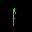

1 expected, 1 found with score 0.957031


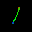

1 expected, 1 found with score 0.941406


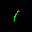

1 expected, 1 found with score 0.996094


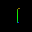

1 expected, 1 found with score 0.996094


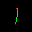

1 expected, 1 found with score 0.984375


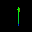

1 expected, 1 found with score 0.976562


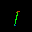

1 expected, 1 found with score 0.917969


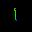

1 expected, 1 found with score 0.980469


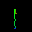

1 expected, 1 found with score 0.988281


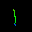

1 expected, 1 found with score 0.972656


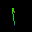

1 expected, 1 found with score 0.937500


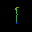

1 expected, 1 found with score 0.914062


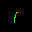

1 expected, 1 found with score 0.996094


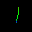

1 expected, 1 found with score 0.769531


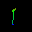

1 expected, 1 found with score 0.992188


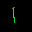

1 expected, 1 found with score 0.996094


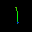

1 expected, 1 found with score 0.964844


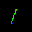

1 expected, 1 found with score 0.953125


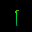

1 expected, 1 found with score 0.906250


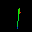

1 expected, 1 found with score 0.988281


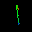

1 expected, 1 found with score 0.996094


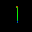

1 expected, 1 found with score 0.980469


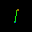

1 expected, 1 found with score 0.988281


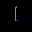

1 expected, 1 found with score 0.847656


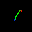

1 expected, 1 found with score 0.996094


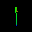

1 expected, 1 found with score 0.921875


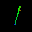

1 expected, 1 found with score 0.968750


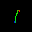

1 expected, 1 found with score 0.761719


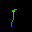

1 expected, 1 found with score 0.984375


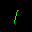

1 expected, 1 found with score 0.960938


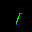

1 expected, 1 found with score 0.992188


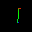

1 expected, 1 found with score 0.988281


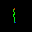

1 expected, 1 found with score 0.996094


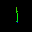

1 expected, 1 found with score 0.992188


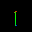

1 expected, 1 found with score 0.988281


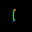

1 expected, 1 found with score 0.992188


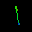

0 expected, 0 found with score 0.992188


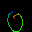

0 expected, 0 found with score 0.914062


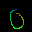

0 expected, 0 found with score 0.996094


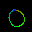

0 expected, 0 found with score 0.972656


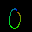

0 expected, 0 found with score 0.937500


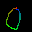

0 expected, 0 found with score 0.937500


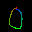

0 expected, 0 found with score 0.996094


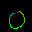

0 expected, 0 found with score 0.941406


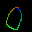

0 expected, 0 found with score 0.878906


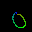

0 expected, 0 found with score 0.988281


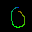

0 expected, 0 found with score 0.996094


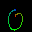

0 expected, 0 found with score 0.957031


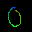

0 expected, 0 found with score 0.859375


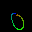

0 expected, 0 found with score 0.968750


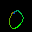

0 expected, 0 found with score 0.996094


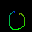

0 expected, 0 found with score 0.929688


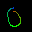

0 expected, 0 found with score 0.875000


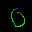

0 expected, 0 found with score 0.972656


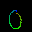

0 expected, 0 found with score 0.839844


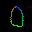

0 expected, 0 found with score 0.988281


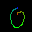

0 expected, 0 found with score 0.929688


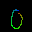

0 expected, 0 found with score 0.996094


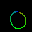

0 expected, 0 found with score 0.996094


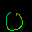

0 expected, 0 found with score 0.812500


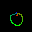

0 expected, 0 found with score 0.968750


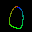

0 expected, 0 found with score 0.851562


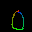

0 expected, 0 found with score 0.992188


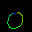

0 expected, 0 found with score 0.910156


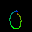

0 expected, 0 found with score 0.996094


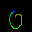

0 expected, 0 found with score 0.972656


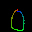

0 expected, 0 found with score 0.984375


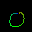

0 expected, 0 found with score 0.960938


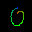

0 expected, 0 found with score 0.824219


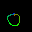

0 expected, 0 found with score 0.968750


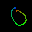

0 expected, 0 found with score 0.992188


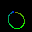

0 expected, 0 found with score 0.894531


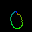

0 expected, 0 found with score 0.988281


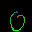

0 expected, 0 found with score 0.980469


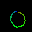

0 expected, 0 found with score 0.953125


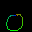

0 expected, 0 found with score 0.882812


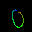

0 expected, 0 found with score 0.984375


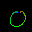

0 expected, 0 found with score 0.812500


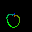

0 expected, 0 found with score 0.992188


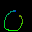

0 expected, 0 found with score 0.824219


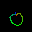

0 expected, 0 found with score 0.859375


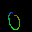

0 expected, 0 found with score 0.980469


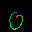

0 expected, 0 found with score 0.949219


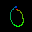

0 expected, 0 found with score 0.996094


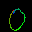

0 expected, 0 found with score 0.988281


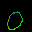

0 expected, 0 found with score 0.984375


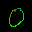

0 expected, 0 found with score 0.976562


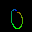

0 expected, 0 found with score 0.964844


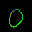

0 expected, 0 found with score 0.996094


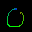

0 expected, 0 found with score 0.941406


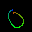

0 expected, 0 found with score 0.859375


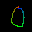

0 expected, 0 found with score 0.773438


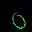

0 expected, 0 found with score 0.988281


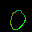

0 expected, 0 found with score 0.996094


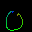

0 expected, 0 found with score 0.968750


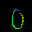

0 expected, 0 found with score 0.996094


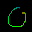

0 expected, 0 found with score 0.843750


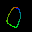

0 expected, 0 found with score 0.992188


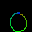

0 expected, 0 found with score 0.984375


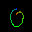

0 expected, 0 found with score 0.929688


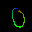

0 expected, 0 found with score 0.964844


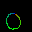

0 expected, 0 found with score 0.992188


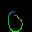

0 expected, 0 found with score 0.996094


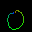

0 expected, 0 found with score 0.949219


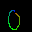

0 expected, 0 found with score 0.957031


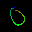

0 expected, 0 found with score 0.800781


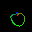

0 expected, 0 found with score 0.996094


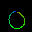

0 expected, 0 found with score 0.992188


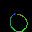

0 expected, 0 found with score 0.898438


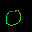

0 expected, 0 found with score 0.988281


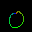

0 expected, 0 found with score 0.953125


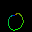

0 expected, 0 found with score 0.984375


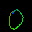

0 expected, 0 found with score 0.921875


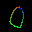

0 expected, 0 found with score 0.972656


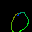

0 expected, 0 found with score 0.988281


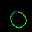

0 expected, 0 found with score 0.992188


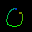

0 expected, 0 found with score 0.996094


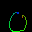

0 expected, 0 found with score 0.933594


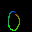

0 expected, 0 found with score 0.937500


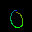

0 expected, 0 found with score 0.960938


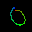

0 expected, 0 found with score 0.996094


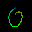

0 expected, 0 found with score 0.996094


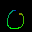

0 expected, 0 found with score 0.964844


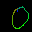

0 expected, 0 found with score 0.996094


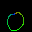

0 expected, 0 found with score 0.996094


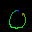

0 expected, 0 found with score 0.964844


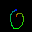

0 expected, 0 found with score 0.992188


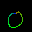

0 expected, 0 found with score 0.945312


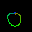

0 expected, 0 found with score 0.976562


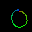

0 expected, 0 found with score 0.820312


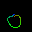

0 expected, 0 found with score 0.980469


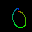

0 expected, 0 found with score 0.976562


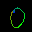

0 expected, 0 found with score 0.902344


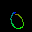

0 expected, 0 found with score 0.937500


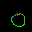

0 expected, 0 found with score 0.972656


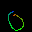

0 expected, 0 found with score 0.988281


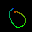

0 expected, 0 found with score 0.980469


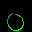

0 expected, 0 found with score 0.750000


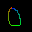

0 expected, 0 found with score 0.945312


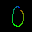

0 expected, 0 found with score 0.976562


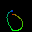

0 expected, 0 found with score 0.953125


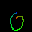

0 expected, 0 found with score 0.992188


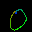

0 expected, 0 found with score 0.984375


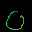

9 expected, 9 found with score 0.867188


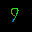

9 expected, 9 found with score 0.878906


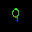

9 expected, 9 found with score 0.750000


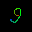

9 expected, 9 found with score 0.945312


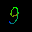

9 expected, 9 found with score 0.835938


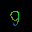

9 expected, 9 found with score 0.988281


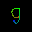

9 expected, 9 found with score 0.914062


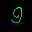

9 expected, 9 found with score 0.980469


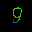

9 expected, 9 found with score 0.882812


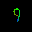

9 expected, 9 found with score 0.820312


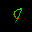

9 expected, 9 found with score 0.968750


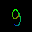

9 expected, 9 found with score 0.949219


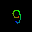

9 expected, 9 found with score 0.796875


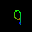

9 expected, 9 found with score 0.980469


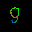

9 expected, 9 found with score 0.867188


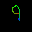

9 expected, 9 found with score 0.984375


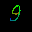

9 expected, 9 found with score 0.902344


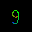

9 expected, 9 found with score 0.828125


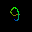

9 expected, 9 found with score 0.980469


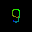

9 expected, 9 found with score 0.851562


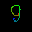

9 expected, 9 found with score 0.929688


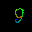

9 expected, 9 found with score 0.781250


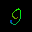

9 expected, 9 found with score 0.832031


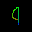

9 expected, 9 found with score 0.855469


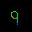

9 expected, 9 found with score 0.976562


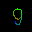

9 expected, 9 found with score 0.796875


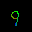

9 expected, 9 found with score 0.941406


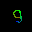

9 expected, 9 found with score 0.781250


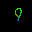

9 expected, 9 found with score 0.765625


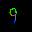

9 expected, 9 found with score 0.765625


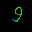

9 expected, 9 found with score 0.914062


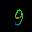

9 expected, 9 found with score 0.945312


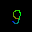

9 expected, 9 found with score 0.898438


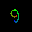

9 expected, 9 found with score 0.941406


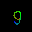

9 expected, 9 found with score 0.941406


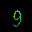

9 expected, 9 found with score 0.839844


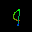

9 expected, 9 found with score 0.781250


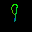

9 expected, 9 found with score 0.984375


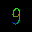

9 expected, 9 found with score 0.910156


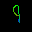

9 expected, 9 found with score 0.910156


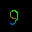

9 expected, 9 found with score 0.886719


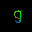

9 expected, 9 found with score 0.953125


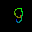

9 expected, 9 found with score 0.894531


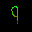

9 expected, 9 found with score 0.949219


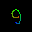

9 expected, 9 found with score 0.976562


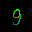

9 expected, 9 found with score 0.902344


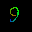

9 expected, 9 found with score 0.925781


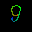

9 expected, 9 found with score 0.906250


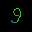

9 expected, 9 found with score 0.984375


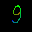

9 expected, 9 found with score 0.937500


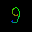

9 expected, 9 found with score 0.933594


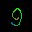

9 expected, 9 found with score 0.964844


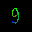

9 expected, 9 found with score 0.835938


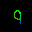

9 expected, 9 found with score 0.894531


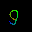

9 expected, 9 found with score 0.921875


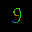

9 expected, 9 found with score 0.750000


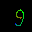

9 expected, 9 found with score 0.882812


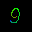

9 expected, 9 found with score 0.898438


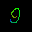

9 expected, 9 found with score 0.941406


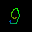

9 expected, 9 found with score 0.902344


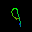

9 expected, 9 found with score 0.898438


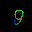

9 expected, 9 found with score 0.937500


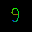

9 expected, 9 found with score 0.773438


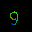

9 expected, 9 found with score 0.964844


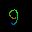

9 expected, 9 found with score 0.976562


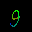

9 expected, 9 found with score 0.859375


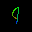

9 expected, 9 found with score 0.757812


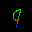

9 expected, 9 found with score 0.875000


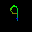

9 expected, 9 found with score 0.972656


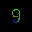

9 expected, 9 found with score 0.898438


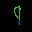

9 expected, 9 found with score 0.972656


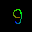

9 expected, 9 found with score 0.875000


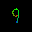

9 expected, 9 found with score 0.925781


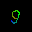

9 expected, 9 found with score 0.910156


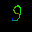

9 expected, 9 found with score 0.945312


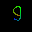

9 expected, 9 found with score 0.808594


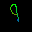

9 expected, 9 found with score 0.832031


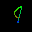

9 expected, 9 found with score 0.976562


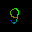

9 expected, 9 found with score 0.875000


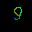

9 expected, 9 found with score 0.949219


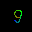

9 expected, 9 found with score 0.812500


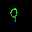

9 expected, 9 found with score 0.929688


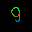

9 expected, 9 found with score 0.976562


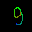

9 expected, 9 found with score 0.871094


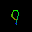

9 expected, 9 found with score 0.933594


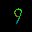

9 expected, 9 found with score 0.968750


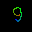

4 expected, 4 found with score 0.984375


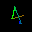

4 expected, 4 found with score 0.992188


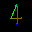

4 expected, 4 found with score 0.960938


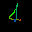

4 expected, 4 found with score 0.957031


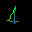

4 expected, 4 found with score 0.960938


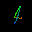

4 expected, 4 found with score 0.964844


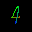

4 expected, 4 found with score 0.976562


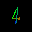

4 expected, 4 found with score 0.835938


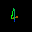

4 expected, 4 found with score 0.996094


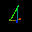

4 expected, 4 found with score 0.789062


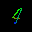

4 expected, 4 found with score 0.929688


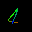

4 expected, 4 found with score 0.867188


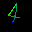

4 expected, 4 found with score 0.933594


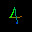

4 expected, 4 found with score 0.980469


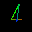

4 expected, 4 found with score 0.925781


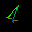

4 expected, 4 found with score 0.996094


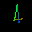

4 expected, 4 found with score 0.839844


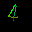

4 expected, 4 found with score 0.832031


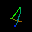

4 expected, 4 found with score 0.976562


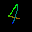

4 expected, 4 found with score 0.980469


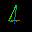

4 expected, 4 found with score 0.910156


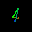

4 expected, 4 found with score 0.980469


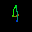

4 expected, 4 found with score 0.859375


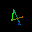

4 expected, 4 found with score 0.976562


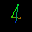

4 expected, 4 found with score 0.941406


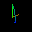

4 expected, 4 found with score 0.917969


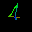

4 expected, 4 found with score 0.972656


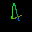

4 expected, 4 found with score 0.925781


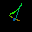

4 expected, 4 found with score 0.921875


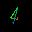

4 expected, 4 found with score 0.917969


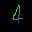

4 expected, 4 found with score 0.988281


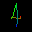

4 expected, 4 found with score 0.906250


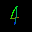

4 expected, 4 found with score 0.937500


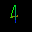

4 expected, 4 found with score 0.894531


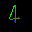

4 expected, 4 found with score 0.953125


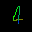

4 expected, 4 found with score 0.980469


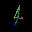

4 expected, 4 found with score 0.921875


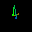

4 expected, 4 found with score 0.992188


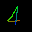

4 expected, 4 found with score 0.996094


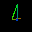

4 expected, 4 found with score 0.960938


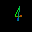

4 expected, 4 found with score 0.855469


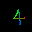

4 expected, 4 found with score 0.984375


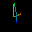

4 expected, 4 found with score 0.898438


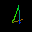

4 expected, 4 found with score 0.957031


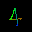

4 expected, 4 found with score 0.949219


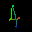

4 expected, 4 found with score 0.988281


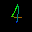

4 expected, 4 found with score 0.941406


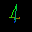

4 expected, 4 found with score 0.957031


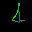

4 expected, 4 found with score 0.976562


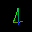

4 expected, 4 found with score 0.851562


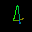

4 expected, 4 found with score 0.773438


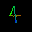

4 expected, 4 found with score 0.906250


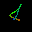

4 expected, 4 found with score 0.964844


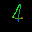

4 expected, 4 found with score 0.996094


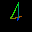

4 expected, 4 found with score 0.945312


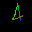

4 expected, 4 found with score 0.980469


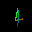

4 expected, 4 found with score 0.941406


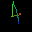

4 expected, 4 found with score 0.882812


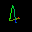

4 expected, 4 found with score 0.996094


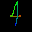

4 expected, 4 found with score 0.972656


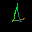

4 expected, 4 found with score 0.953125


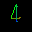

4 expected, 4 found with score 0.953125


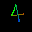

4 expected, 4 found with score 0.960938


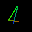

4 expected, 4 found with score 0.996094


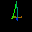

4 expected, 4 found with score 0.984375


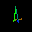

4 expected, 4 found with score 0.976562


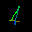

4 expected, 4 found with score 0.898438


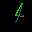

4 expected, 4 found with score 0.972656


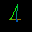

4 expected, 4 found with score 0.863281


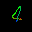

4 expected, 4 found with score 0.867188


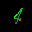

4 expected, 4 found with score 0.968750


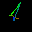

4 expected, 4 found with score 0.984375


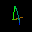

4 expected, 4 found with score 0.992188


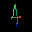

4 expected, 4 found with score 0.867188


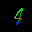

4 expected, 4 found with score 0.976562


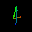

4 expected, 4 found with score 0.953125


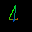

4 expected, 4 found with score 0.984375


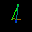

4 expected, 4 found with score 0.960938


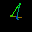

4 expected, 4 found with score 0.945312


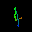

4 expected, 4 found with score 0.890625


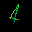

4 expected, 4 found with score 0.835938


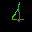

4 expected, 4 found with score 0.945312


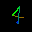

4 expected, 4 found with score 0.937500


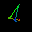

4 expected, 4 found with score 0.875000


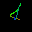

4 expected, 4 found with score 0.972656


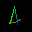

4 expected, 4 found with score 0.964844


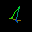

4 expected, 4 found with score 0.980469


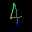

4 expected, 4 found with score 0.992188


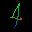

4 expected, 4 found with score 0.949219


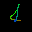

4 expected, 4 found with score 0.968750


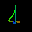

4 expected, 4 found with score 0.937500


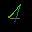

4 expected, 4 found with score 0.859375


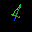

4 expected, 4 found with score 0.953125


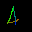

4 expected, 4 found with score 0.941406


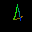

4 expected, 4 found with score 0.957031


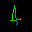

4 expected, 4 found with score 0.996094


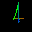

4 expected, 4 found with score 0.828125


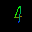

4 expected, 4 found with score 0.976562


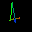

4 expected, 4 found with score 0.886719


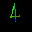

4 expected, 4 found with score 0.777344


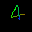

4 expected, 4 found with score 0.933594


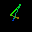

4 expected, 4 found with score 0.953125


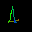

4 expected, 4 found with score 0.957031


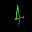

4 expected, 4 found with score 0.960938


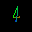

4 expected, 4 found with score 0.964844


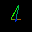

4 expected, 4 found with score 0.992188


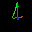

4 expected, 4 found with score 0.867188


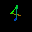

4 expected, 4 found with score 0.851562


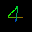

4 expected, 4 found with score 0.988281


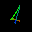

4 expected, 4 found with score 0.984375


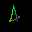

4 expected, 4 found with score 0.968750


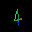

4 expected, 4 found with score 0.988281


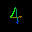

4 expected, 4 found with score 0.984375


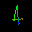

4 expected, 4 found with score 0.871094


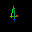

4 expected, 4 found with score 0.984375


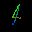

4 expected, 4 found with score 0.988281


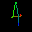

4 expected, 4 found with score 0.992188


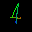

4 expected, 4 found with score 0.984375


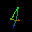

4 expected, 4 found with score 0.824219


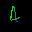

4 expected, 4 found with score 0.898438


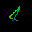

4 expected, 4 found with score 0.992188


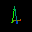

4 expected, 4 found with score 0.917969


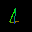

4 expected, 4 found with score 0.992188


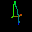

4 expected, 4 found with score 0.964844


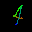

4 expected, 4 found with score 0.921875


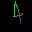

4 expected, 4 found with score 0.933594


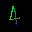

4 expected, 4 found with score 0.937500


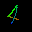

4 expected, 4 found with score 0.914062


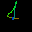

4 expected, 4 found with score 0.929688


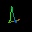

4 expected, 4 found with score 0.875000


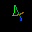

4 expected, 4 found with score 0.964844


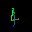

4 expected, 4 found with score 0.992188


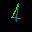

2 expected, 2 found with score 0.957031


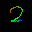

2 expected, 2 found with score 0.949219


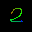

2 expected, 2 found with score 0.820312


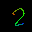

2 expected, 2 found with score 0.839844


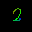

2 expected, 2 found with score 0.765625


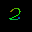

2 expected, 2 found with score 0.773438


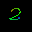

2 expected, 2 found with score 0.757812


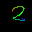

2 expected, 2 found with score 0.785156


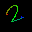

2 expected, 2 found with score 0.937500


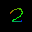

2 expected, 2 found with score 0.906250


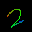

2 expected, 2 found with score 0.750000


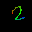

2 expected, 2 found with score 0.894531


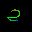

2 expected, 2 found with score 0.859375


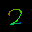

2 expected, 2 found with score 0.820312


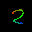

2 expected, 2 found with score 0.824219


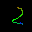

2 expected, 2 found with score 0.890625


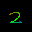

2 expected, 2 found with score 0.910156


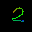

2 expected, 2 found with score 0.781250


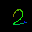

2 expected, 2 found with score 0.863281


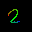

2 expected, 2 found with score 0.824219


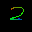

2 expected, 2 found with score 0.792969


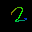

2 expected, 2 found with score 0.957031


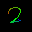

2 expected, 2 found with score 0.878906


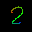

2 expected, 2 found with score 0.828125


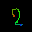

2 expected, 2 found with score 0.871094


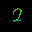

2 expected, 2 found with score 0.894531


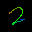

2 expected, 2 found with score 0.843750


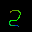

2 expected, 2 found with score 0.750000


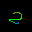

2 expected, 2 found with score 0.875000


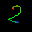

2 expected, 2 found with score 0.910156


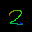

2 expected, 2 found with score 0.886719


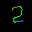

2 expected, 2 found with score 0.781250


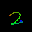

2 expected, 2 found with score 0.953125


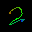

2 expected, 2 found with score 0.757812


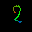

2 expected, 2 found with score 0.890625


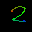

2 expected, 2 found with score 0.875000


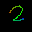

2 expected, 2 found with score 0.859375


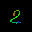

2 expected, 2 found with score 0.777344


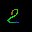

2 expected, 2 found with score 0.894531


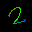

2 expected, 2 found with score 0.792969


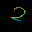

2 expected, 2 found with score 0.777344


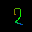

2 expected, 2 found with score 0.863281


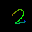

2 expected, 2 found with score 0.867188


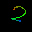

2 expected, 2 found with score 0.800781


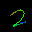

2 expected, 2 found with score 0.917969


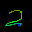

2 expected, 2 found with score 0.925781


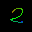

2 expected, 2 found with score 0.917969


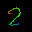

2 expected, 2 found with score 0.828125


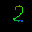

2 expected, 2 found with score 0.863281


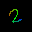

2 expected, 2 found with score 0.828125


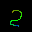

2 expected, 2 found with score 0.847656


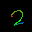

2 expected, 2 found with score 0.800781


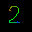

2 expected, 2 found with score 0.937500


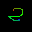

2 expected, 2 found with score 0.851562


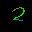

2 expected, 2 found with score 0.839844


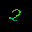

2 expected, 2 found with score 0.906250


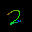

2 expected, 2 found with score 0.855469


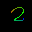

2 expected, 2 found with score 0.867188


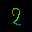

2 expected, 2 found with score 0.800781


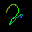

2 expected, 2 found with score 0.820312


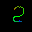

2 expected, 2 found with score 0.765625


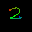

2 expected, 2 found with score 0.953125


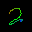

2 expected, 2 found with score 0.820312


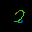

2 expected, 2 found with score 0.878906


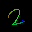

2 expected, 2 found with score 0.925781


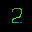

2 expected, 2 found with score 0.941406


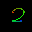

2 expected, 2 found with score 0.855469


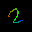

2 expected, 2 found with score 0.796875


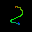

2 expected, 2 found with score 0.878906


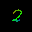

2 expected, 2 found with score 0.812500


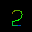

2 expected, 2 found with score 0.785156


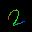

2 expected, 2 found with score 0.757812


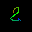

2 expected, 2 found with score 0.750000


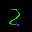

2 expected, 2 found with score 0.796875


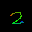

2 expected, 2 found with score 0.781250


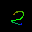

2 expected, 2 found with score 0.773438


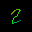

2 expected, 2 found with score 0.851562


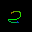

2 expected, 2 found with score 0.972656


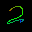

2 expected, 2 found with score 0.832031


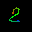

2 expected, 2 found with score 0.910156


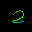

2 expected, 2 found with score 0.781250


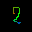

2 expected, 2 found with score 0.785156


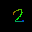

2 expected, 2 found with score 0.769531


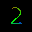

2 expected, 2 found with score 0.785156


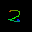

2 expected, 2 found with score 0.757812


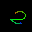

2 expected, 2 found with score 0.937500


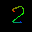

2 expected, 2 found with score 0.921875


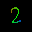

2 expected, 2 found with score 0.781250


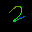

2 expected, 2 found with score 0.945312


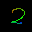

2 expected, 2 found with score 0.882812


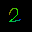

2 expected, 2 found with score 0.886719


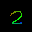

2 expected, 2 found with score 0.820312


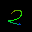

2 expected, 2 found with score 0.960938


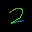

2 expected, 2 found with score 0.972656


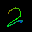

2 expected, 2 found with score 0.886719


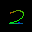

2 expected, 2 found with score 0.949219


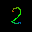

2 expected, 2 found with score 0.839844


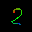

2 expected, 2 found with score 0.867188


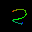

2 expected, 2 found with score 0.878906


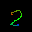

2 expected, 2 found with score 0.906250


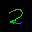

2 expected, 2 found with score 0.902344


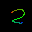

2 expected, 2 found with score 0.863281


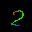

2 expected, 2 found with score 0.777344


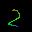

2 expected, 2 found with score 0.792969


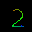

2 expected, 2 found with score 0.921875


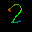

2 expected, 2 found with score 0.851562


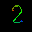

2 expected, 2 found with score 0.871094


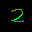

2 expected, 2 found with score 0.871094


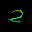

2 expected, 2 found with score 0.925781


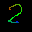

2 expected, 2 found with score 0.871094


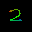

2 expected, 2 found with score 0.773438


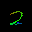

2 expected, 2 found with score 0.941406


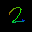

2 expected, 2 found with score 0.761719


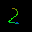

2 expected, 2 found with score 0.902344


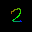

2 expected, 2 found with score 0.820312


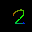

2 expected, 2 found with score 0.945312


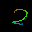

2 expected, 2 found with score 0.882812


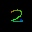

2 expected, 2 found with score 0.753906


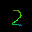

2 expected, 2 found with score 0.925781


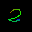

2 expected, 2 found with score 0.812500


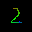

2 expected, 2 found with score 0.785156


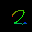

2 expected, 2 found with score 0.882812


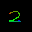

2 expected, 2 found with score 0.937500


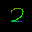

2 expected, 2 found with score 0.902344


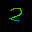

2 expected, 2 found with score 0.796875


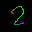

2 expected, 2 found with score 0.808594


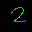

2 expected, 2 found with score 0.886719


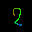

2 expected, 2 found with score 0.890625


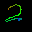

2 expected, 2 found with score 0.929688


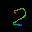

2 expected, 2 found with score 0.757812


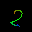

2 expected, 2 found with score 0.937500


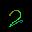

2 expected, 2 found with score 0.910156


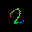

2 expected, 2 found with score 0.898438


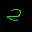

2 expected, 2 found with score 0.875000


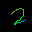

2 expected, 2 found with score 0.824219


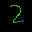

2 expected, 2 found with score 0.875000


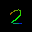

2 expected, 2 found with score 0.945312


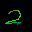

2 expected, 2 found with score 0.875000


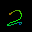

2 expected, 2 found with score 0.890625


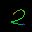

2 expected, 2 found with score 0.980469


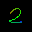

2 expected, 2 found with score 0.867188


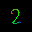

2 expected, 2 found with score 0.753906


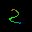

2 expected, 2 found with score 0.785156


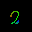

2 expected, 2 found with score 0.777344


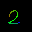

2 expected, 2 found with score 0.941406


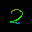

2 expected, 2 found with score 0.890625


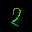

2 expected, 2 found with score 0.796875


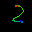

2 expected, 2 found with score 0.945312


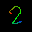

2 expected, 2 found with score 0.750000


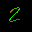

2 expected, 2 found with score 0.800781


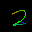

2 expected, 2 found with score 0.753906


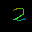

8 expected, 8 found with score 0.906250


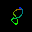

8 expected, 8 found with score 0.972656


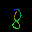

8 expected, 8 found with score 0.914062


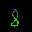

8 expected, 8 found with score 0.953125


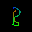

8 expected, 8 found with score 0.910156


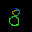

8 expected, 8 found with score 0.929688


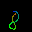

8 expected, 8 found with score 0.917969


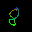

8 expected, 8 found with score 0.910156


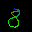

8 expected, 8 found with score 0.902344


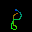

8 expected, 8 found with score 0.949219


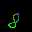

8 expected, 8 found with score 0.968750


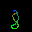

8 expected, 8 found with score 0.941406


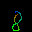

8 expected, 8 found with score 0.968750


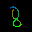

8 expected, 8 found with score 0.804688


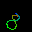

8 expected, 8 found with score 0.957031


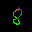

8 expected, 8 found with score 0.984375


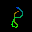

8 expected, 8 found with score 0.886719


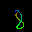

8 expected, 8 found with score 0.937500


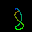

8 expected, 8 found with score 0.972656


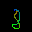

8 expected, 8 found with score 0.976562


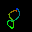

8 expected, 8 found with score 0.960938


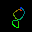

8 expected, 8 found with score 0.941406


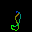

8 expected, 8 found with score 0.917969


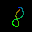

8 expected, 8 found with score 0.968750


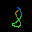

8 expected, 8 found with score 0.968750


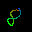

8 expected, 8 found with score 0.796875


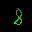

8 expected, 8 found with score 0.964844


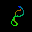

8 expected, 8 found with score 0.941406


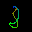

8 expected, 8 found with score 0.953125


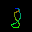

8 expected, 8 found with score 0.945312


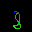

8 expected, 8 found with score 0.972656


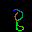

8 expected, 8 found with score 0.878906


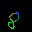

8 expected, 8 found with score 0.906250


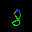

8 expected, 8 found with score 0.917969


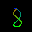

8 expected, 8 found with score 0.898438


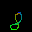

8 expected, 8 found with score 0.984375


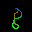

8 expected, 8 found with score 0.929688


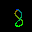

8 expected, 8 found with score 0.972656


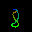

8 expected, 8 found with score 0.867188


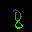

8 expected, 8 found with score 0.921875


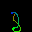

8 expected, 8 found with score 0.902344


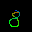

8 expected, 8 found with score 0.945312


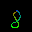

8 expected, 8 found with score 0.929688


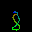

8 expected, 8 found with score 0.960938


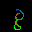

8 expected, 8 found with score 0.902344


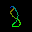

8 expected, 8 found with score 0.941406


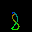

8 expected, 8 found with score 0.960938


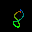

8 expected, 8 found with score 0.910156


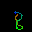

8 expected, 8 found with score 0.882812


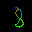

8 expected, 8 found with score 0.914062


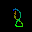

8 expected, 8 found with score 0.960938


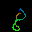

8 expected, 8 found with score 0.910156


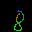

8 expected, 8 found with score 0.960938


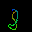

8 expected, 8 found with score 0.941406


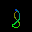

8 expected, 8 found with score 0.941406


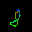

8 expected, 8 found with score 0.925781


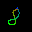

8 expected, 8 found with score 0.917969


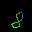

8 expected, 8 found with score 0.921875


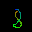

8 expected, 8 found with score 0.753906


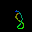

8 expected, 8 found with score 0.871094


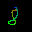

8 expected, 8 found with score 0.980469


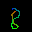

8 expected, 8 found with score 0.875000


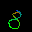

8 expected, 8 found with score 0.820312


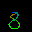

8 expected, 8 found with score 0.960938


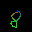

8 expected, 8 found with score 0.976562


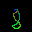

8 expected, 8 found with score 0.914062


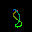

8 expected, 8 found with score 0.984375


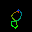

8 expected, 8 found with score 0.878906


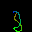

8 expected, 8 found with score 0.910156


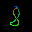

8 expected, 8 found with score 0.867188


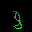

8 expected, 8 found with score 0.902344


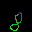

8 expected, 8 found with score 0.914062


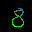

8 expected, 8 found with score 0.902344


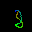

8 expected, 8 found with score 0.941406


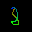

8 expected, 8 found with score 0.968750


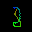

8 expected, 8 found with score 0.980469


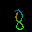

8 expected, 8 found with score 0.957031


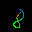

8 expected, 8 found with score 0.960938


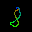

8 expected, 8 found with score 0.945312


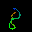

8 expected, 8 found with score 0.839844


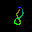

8 expected, 8 found with score 0.902344


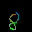

8 expected, 8 found with score 0.960938


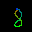

8 expected, 8 found with score 0.835938


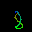

0.0% correct (N=998, 388 unknown)


In [89]:
from IPython.display import Image, display

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob("test/*"):
    label = label_dir.replace("test/", "")
    flag = 1 if label in ["star", "square", "circle"] else (2 if label in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] else 3)
    for filename in glob.glob(label_dir + "/*.png"):
        index, score = predict_tflite(model_tflite, filename)
        if score < 0.75:
            discarded_count += 1
            continue
        if index == label:
            correct_count += 1
        else:
            wrong_count += 1
            print("%s expected, %d found with score %f" % (label, index, score))
            display(Image(filename=filename))

correct_percentage = (correct_count / (correct_count + wrong_count)) * 100

print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))


In [90]:
import os
import pandas as pd

def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,655804 bytes,
TensorFlow Lite,101936 bytes,(reduced by 553868 bytes)
TensorFlow Lite Quantized,31768 bytes,(reduced by 70168 bytes)


In [91]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [825 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,371 kB]
Get:13 http://archive.ubuntu.com/ubun

In [92]:
# Print the C source file
!tail {TFL_CC_MODEL_FILENAME}

  0x2c, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xd0, 0xff, 0xff, 0xff, 0x19, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x19, 0xe0, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 0xf0, 0xff, 0xff, 0xff,
  0x28, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x28,
  0x0c, 0x00, 0x10, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x03
};
unsigned int g_magic_wand_model_data_len = 31768;
